In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
# Read in file
d_df = pd.read_csv('../data/IRD/deaths.csv')
c_df = pd.read_csv('../data/IRD/confirmed.csv')
# Drop China and Diamond Princess
for c in ['China', 'Diamond Princess']:
    c_df = c_df[c_df['Country/Region']!=c]
    d_df = d_df[d_df['Country/Region']!=c]
d_df['Country/Region'].iloc[~d_df['Province/State'].isnull().values] += ' / '+d_df['Province/State']
c_df['Country/Region'].iloc[~c_df['Province/State'].isnull().values] += ' / '+c_df['Province/State']
d_df = d_df.drop(columns=['Province/State', 'Lat', 'Long'])
c_df = c_df.drop(columns=['Province/State', 'Lat', 'Long'])
d_df.set_index(keys='Country/Region', inplace=True)
c_df.set_index(keys='Country/Region', inplace=True)
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>10)]

In [7]:
deaths = {}
cases = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
            cases[country] = c_df.T[country].values[start_days[i]:end_days[i]]
        else:
            deaths[country] = d_df.T[country].values[start_days[i]:]
            cases[country] = c_df.T[country].values[start_days[i]:]

In [8]:
len(deaths)

80

In [72]:
bcg = pd.read_csv('../data/BCG/BCG_ATLAS.csv', index_col='Country')
NONBCG = ['US', 'Italy', 'Netherlands', 'Belgium', 
         'Lebanon']#, 'Indonesia', 'Iran']#, 'Ecuador', 'Andorra', 'Luxembourg']
BCG = ['Brazil', 'Peru', 'India', 'Romania', 'Turkey', 
       'Bulgaria', 'Mexico', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Finland', 
       'United Kingdom', 'Poland', 'Ireland', 'France', 
       'Austria']#, 'Denmark', ], 'Germany', 'Jordan', 'Kazakhstan']
nonbcg = bcg.T[NONBCG].T
bcg = bcg.T[BCG].T

In [73]:
testp1k = dict([['US', 1.306],
                ['Italy', 1.455],
                ['Netherlands', 4.029],
                ['Belgium', 5.542999999999999],
                ['Peru', 1.702],
                ['India', 0.11699999999999999],
                ['Romania', 2.859],
                ['Turkey', 3.2960000000000003],
                ['Mexico', 0.17600000000000002],
                ['Slovenia', 16.464000000000002],
                ['Finland', 8.017999999999999],
                ['United Kingdom', 1.69],
                ['Poland', 3.1180000000000003],
                ['Ireland', 8.692],
                ['France', 1.636],
                ['Austria', 15.343]])

In [74]:
# testp1k = pd.DataFrame(data=[['US', 1.306],
#                             ['Italy', 1.455],
#                             ['Netherlands', 4.029],
#                             ['Belgium', 5.542999999999999],
#                             ['Peru', 1.702],
#                             ['India', 0.11699999999999999],
#                             ['Romania', 2.859],
#                             ['Turkey', 3.2960000000000003],
#                             ['Mexico', 0.17600000000000002],
#                             ['Slovenia', 16.464000000000002],
#                             ['Finland', 8.017999999999999],
#                             ['United Kingdom', 1.69],
#                             ['Poland', 3.1180000000000003],
#                             ['Ireland', 8.692],
#                             ['France', 1.636],
#                             ['Austria', 15.343]], columns=['Country', 'Test per 1k'])
# testp1k.set_index('Country', inplace=True)

In [33]:
bcg_countries = list(bcg.index.intersection(deaths.keys()))
nonbcg_countries = list(nonbcg.index.intersection(deaths.keys()))
# bcg_countries = list(bcg[bcg['WBIG']<3].index.intersection(deaths.keys()))
bcg_countries = list(set(testp1k.keys()).intersection(bcg_countries))
nonbcg_countries = list(set(testp1k.keys()).intersection(nonbcg_countries))

In [34]:
nonbcg_countries, bcg_countries, len(nonbcg_countries), len(bcg_countries), len(nonbcg_countries)+len(bcg_countries)

(['US', 'Belgium', 'Netherlands', 'Italy'],
 ['Peru',
  'Ireland',
  'Mexico',
  'United Kingdom',
  'Turkey',
  'Poland',
  'Finland',
  'France',
  'India',
  'Austria',
  'Romania',
  'Slovenia'],
 4,
 12,
 16)

In [35]:
pops = transform.population()

Number of unmatched regions : 46
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [36]:
len(nonbcg_countries+bcg_countries)

16

In [15]:
pos

NameError: name 'pos' is not defined

In [37]:
# testp1k['Test per 1k'][c]#/pops.T['Population'][nonbcg_countries+bcg_countries]

In [38]:
pops.T['Population'][nonbcg_countries+bcg_countries]

US                 331002651
Belgium             11589623
Netherlands         17134872
Italy               60461826
Peru                32971854
Ireland              4937786
Mexico             128932753
United Kingdom      67886011
Turkey              84339067
Poland              37846611
Finland              5540720
France              65273511
India             1380004385
Austria              9006398
Romania             19237691
Slovenia             2078938
Name: Population, dtype: int64

In [41]:
posp1k = {}
posptest = {}
for c in nonbcg_countries+bcg_countries:
    posp1k[c] = cases[c][-1]/pops.T['Population'][c]*1000
    posptest[c] = posp1k[c]/testp1k[c]

In [42]:
posp1k

{'US': 0.1987234839397102,
 'Belgium': 1.2048709436018754,
 'Netherlands': 0.6857360825339109,
 'Italy': 0.20611352359751753,
 'Peru': 0.17884951207172034,
 'Ireland': 1.6381835907833997,
 'Mexico': 0.026688331086826323,
 'United Kingdom': 0.21422675726225834,
 'Turkey': 0.5013335041991868,
 'Poland': 0.15734566035516365,
 'Finland': 0.4997545445357282,
 'France': 0.3041969046218458,
 'India': 0.005505779606635091,
 'Austria': 1.5050411940489417,
 'Romania': 0.2841817139073499,
 'Slovenia': 0.557977197973196}

In [43]:
posptest

{'US': 0.15216193257251928,
 'Belgium': 0.21736802157710186,
 'Netherlands': 0.17020007012507096,
 'Italy': 0.14165877910482302,
 'Peru': 0.10508196948984744,
 'Ireland': 0.1884702704536815,
 'Mexico': 0.1516382448115132,
 'United Kingdom': 0.12676139482973867,
 'Turkey': 0.1521036117109183,
 'Poland': 0.050463649889404626,
 'Finland': 0.06232907764227093,
 'France': 0.18593942825296197,
 'India': 0.04705794535585548,
 'Austria': 0.09809301923019889,
 'Romania': 0.09939899052373205,
 'Slovenia': 0.03389074331712803}

In [79]:
df

,Positive per 1k
US,NaN
Italy,NaN
Netherlands,NaN
Belgium,NaN
Peru,NaN
India,NaN
Romania,NaN
Turkey,NaN
Mexico,NaN
Slovenia,NaN


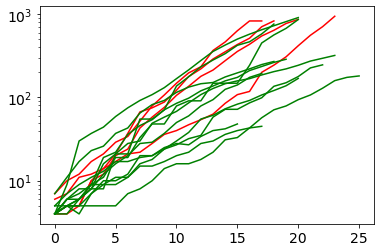

In [44]:
for i, c in enumerate(nonbcg_countries):
    plt.semilogy(deaths[c], 'r')
for i, c in enumerate(bcg_countries):
    plt.semilogy(deaths[c], 'g')

In [45]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

# Bayesian Model

In [46]:
def model():
    
    N_bcg = len(bcg_countries)
    N_nbcg = len(nonbcg_countries)
    N = N_nbcg + N_bcg
    
    # Initial Deaths for each group
    Di_bcg = normalHP('Di_bcg', 7.0, 3.0, N_bcg)
    Di_nbcg = normalHP('Di_nbcg', 7.0, 3.0, N_nbcg)
    # Base Growth Rate for each group
    GR_bcg = normalHP('GR_bcg', 1.3, 0.5, N_bcg)
    GR_nbcg = normalHP('GR_nbcg', 1.3, 0.5, N_nbcg) 
    # Coefficient for positives per test
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.1))
    # Coeffcient for tests per 1k people
    beta = numpyro.sample('beta', dist.Normal(0.0, 0.1))
    
        
    # Create likelihood for each country    
    
    for i, country in enumerate(bcg_countries):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = Di_bcg[i]*(GR_bcg[i]+alpha*posptest[country]+beta*testp1k[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)
        
    for i, country in enumerate(nonbcg_countries):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = Di_nbcg[i]*(GR_nbcg[i]+alpha*posptest[country]+beta*testp1k[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [47]:
N_bcg = len(bcg_countries)
N_nbcg = len(nonbcg_countries)
N = N_nbcg + N_bcg

init_params = {'Di_bcg_grp_mean': 7.0*np.ones((N_chains, 1)),
               'GR_bcg_grp_mean': 1.3*np.ones((N_chains, 1)),
               'Di_bcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_bcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Di_bcg_ind': 7.0*np.ones((N_chains, N_bcg)),
               'GR_bcg_ind': 1.3*np.ones((N_chains, N_bcg)),
               'Di_nbcg_grp_mean': 0.1*np.ones((N_chains, 1)),
               'GR_nbcg_grp_mean': 1.3*np.ones((N_chains, 1)),
               'Di_nbcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_nbcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Di_nbcg_ind': 7.0*np.ones((N_chains, N_nbcg)),
               'GR_nbcg_ind': 1.3*np.ones((N_chains, N_nbcg)),
               'alpha': 0.0*np.ones((N_chains, 1)),
               'beta': 0.0*np.ones((N_chains, 1))
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [48]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 1974.5885310173035 s


In [49]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.2.2.1_BHM_BCG_EXP_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  Di_bcg_grp_mean[0]      8.96      1.59      8.98      6.39     11.57  13572.56      1.00
 Di_bcg_grp_sigma[0]      6.39      1.06      6.29      4.67      7.97  12903.39      1.00
       Di_bcg_ind[0]      5.10      0.55      5.07      4.19      5.98  12784.86      1.00
       Di_bcg_ind[1]     12.27      0.91     12.25     10.81     13.79  14246.28      1.00
       Di_bcg_ind[2]      5.53      0.60      5.51      4.56      6.51  11760.67      1.00
       Di_bcg_ind[3]      8.88      0.61      8.86      7.87      9.89  14341.67      1.00
       Di_bcg_ind[4]     26.13      1.20     26.10     24.11     28.05  15627.85      1.00
       Di_bcg_ind[5]      2.88      0.32      2.87      2.36      3.39  14340.42      1.00
       Di_bcg_ind[6]      7.31      0.96      7.28      5.76      8.88  12724.48      1.00
       Di_bcg_ind[7]      4.32      0.35      4.31      3.75      4.88  14297.75      1.0

In [56]:
samples = {}
with h5py.File('../data/nb_samples/4.2.2.1_BHM_BCG_EXP_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [57]:
for a in zip(bcg_countries, zip(np.mean(samples['GR_bcg_ind'], axis=0), np.std(samples['GR_bcg_ind'], axis=0))):
    print(a)

('Peru', (1.198314, 0.013798682))
('Ireland', (1.2288291, 0.029317036))
('Mexico', (1.2310234, 0.01752827))
('United Kingdom', (1.2869786, 0.014390097))
('Turkey', (1.2129322, 0.017448507))
('Poland', (1.2015586, 0.011385571))
('Finland', (1.1808816, 0.024339898))
('France', (1.3003638, 0.01947351))
('India', (1.1997575, 0.008111793))
('Austria', (1.2337025, 0.03979159))
('Romania', (1.1796738, 0.013406942))
('Slovenia', (1.2330124, 0.04120571))


In [58]:
for a in zip(nonbcg_countries, zip(np.mean(samples['GR_nbcg_ind'], axis=0), np.std(samples['GR_nbcg_ind'], axis=0))):
    print(a)

('US', (1.2723902, 0.015952542))
('Belgium', (1.3096585, 0.025988165))
('Netherlands', (1.2758266, 0.020085355))
('Italy', (1.3206578, 0.015644614))


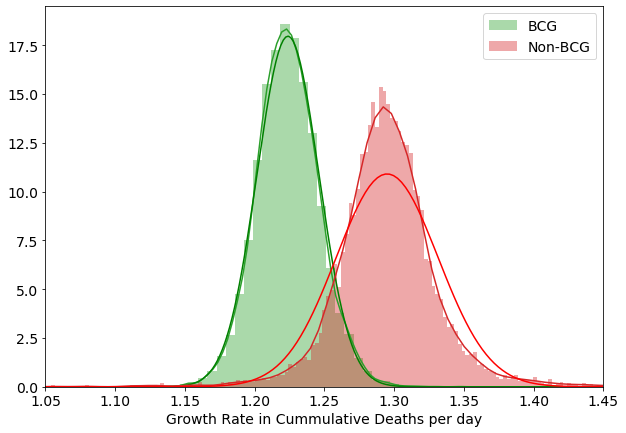

In [59]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['GR_bcg_grp_mean'], bins=50, fit=norm, 
             fit_kws={'color':'green'}, color='tab:green', label='BCG')
sns.distplot(samples['GR_nbcg_grp_mean'], bins=200, fit=norm, 
             fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
plt.xlabel(r'Growth Rate in Cummulative Deaths per day')
plt.xlim(1.05, 1.45)
plt.legend()
# plt.savefig('../plots/4.2.1_Growth_Rate_BCG_Parents.png', dpi=200)

Text(0.5, 0, 'Growth Rate in Cummulative Deaths per day')

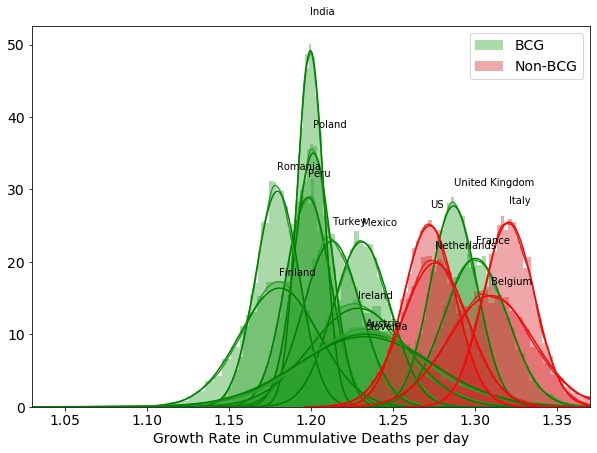

In [67]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['GR_bcg_ind'][:,i])
    std = np.std(samples['GR_bcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')
        
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['GR_nbcg_ind'][:,i])
    std = np.std(samples['GR_nbcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')
    
plt.legend()
plt.xlim(1.03, 1.37)
plt.xlabel(r'Growth Rate in Cummulative Deaths per day')
# plt.savefig('../plots/4.2.1_Death_Growth_Rate_Countries.png', dpi=200)

Text(0.5, 0, 'Coefficient for Positives per Test')

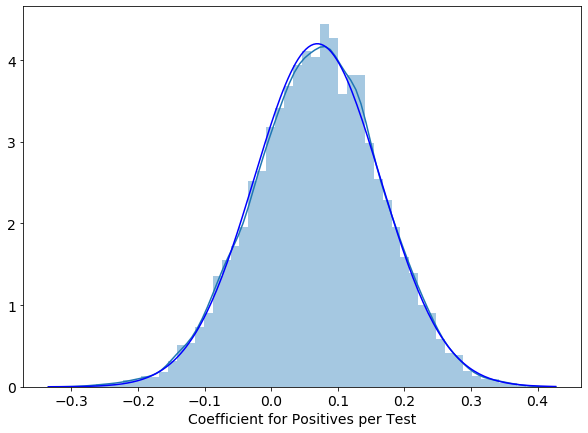

In [71]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.xlabel('Coefficient for Positives per Test')

Text(0.5, 0, 'Coefficient for Tests per 1k')

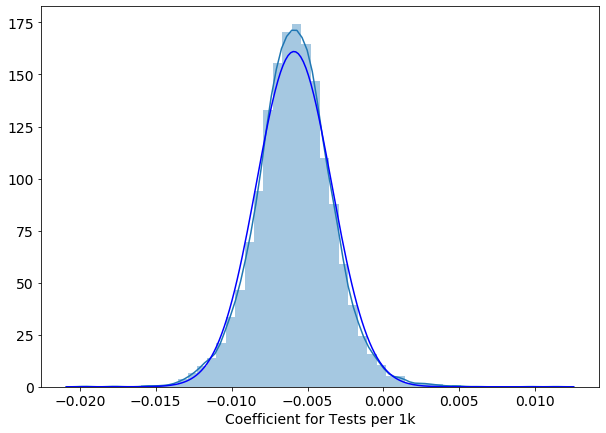

In [70]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['beta'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.xlabel('Coefficient for Tests per 1k')

# Example Plots

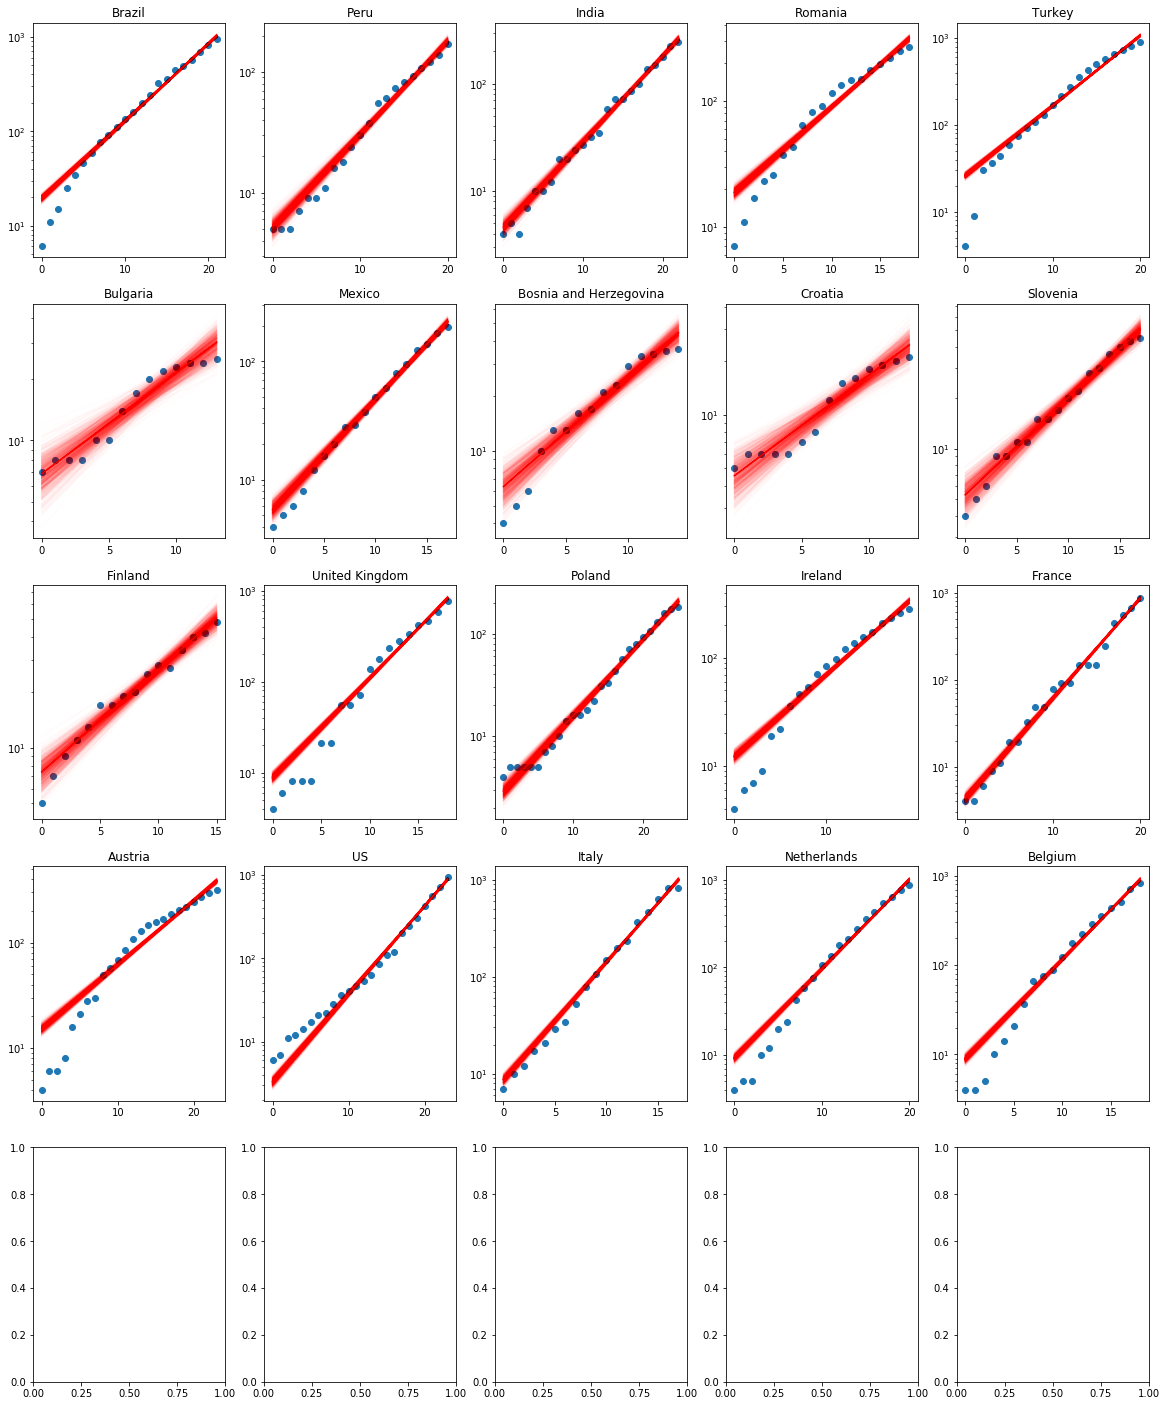

In [21]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(5, 5, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_countries):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy(np.mean(samples['Di_bcg_ind'][:,i])*np.mean(samples['GR_bcg_ind'][:,i])**t, 'r')
    a[i].semilogy((samples['Di_bcg_ind'][::10,i:i+1]*samples['GR_bcg_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)

for i, c in enumerate(nonbcg_countries):
    t = np.arange(len(deaths[c]))
    a[N_bcg+i].set_title(c)
    a[N_bcg+i].semilogy(deaths[c], 'o')
    a[N_bcg+i].semilogy(np.mean(samples['Di_nbcg_ind'][:,i])*np.mean(samples['GR_nbcg_ind'][:,i])**t, 'r')
    a[N_bcg+i].semilogy((samples['Di_nbcg_ind'][::10,i:i+1]*samples['GR_nbcg_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.2.1_ExampleFits.png', dpi=200) 
plt.rcParams['font.size'] = 14

# Trace Plots

Text(0, 0.5, 'Growth Rate')

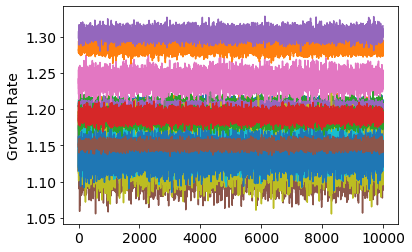

In [22]:
plt.plot(samples['GR_bcg_ind'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Growth Rate')

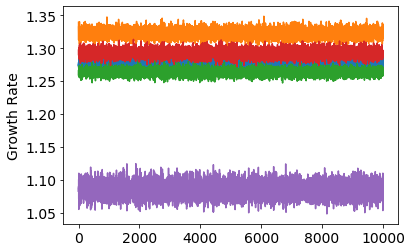

In [23]:
plt.plot(samples['GR_nbcg_ind'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Initial Deaths')

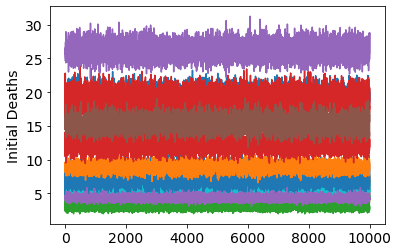

In [24]:
plt.plot(samples['Di_bcg_ind'])
plt.ylabel('Initial Deaths')

Text(0, 0.5, 'Initial Deaths')

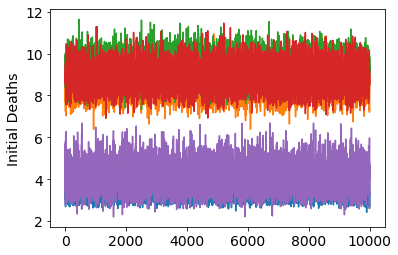

In [25]:
plt.plot(samples['Di_nbcg_ind'])
plt.ylabel('Initial Deaths')